In [1]:
from pathlib import Path
import pandas as pd
from src.diffusivity import (
    within_ellipsoid, 
    calculate_lsq_diffusivities, 
    within_diffusivity_envelope, 
    linear_diffusivity
    )
from src.plots import (
    make_segregation_stage_overlay,
    make_diffusivity_comparison_plot
)

In [2]:
bayes_diffusivity = pd.read_csv('outputs/complete_bayes_diffusivity_results.csv')

In [6]:
bayes_diffusivity

,WellID,Stage,model,mean_Do_x,mean_Do_y,mean_Do_z,sd_Do_x,sd_Do_y,sd_Do_z,hdi_3%_Do_x,hdi_3%_Do_y,hdi_3%_Do_z,hdi_97%_Do_x,hdi_97%_Do_y,hdi_97%_Do_z
0,4,2,linear,5.077,0.001,0.156,0.254,0.001,0.017,4.589,0.000,0.128,5.370,0.001,0.194
1,4,2,nonlinear,0.689,0.001,0.046,0.081,0.001,0.005,0.535,0.000,0.036,0.848,0.002,0.055
2,4,3,linear,6.835,0.517,0.487,0.116,0.062,0.031,6.669,0.417,0.445,7.071,0.625,0.544
3,4,3,nonlinear,1.702,0.518,0.153,0.188,0.062,0.016,1.343,0.418,0.121,2.048,0.627,0.179
4,4,4,linear,4.933,0.561,0.557,0.041,0.015,0.018,4.850,0.536,0.523,5.005,0.591,0.592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2,19,nonlinear,1.899,1.754,1.611,0.223,0.054,0.190,1.489,1.671,1.256,2.260,1.872,1.918
345,2,20,linear,4.845,0.565,1.702,0.032,0.004,0.015,4.790,0.558,1.674,4.914,0.573,1.733
346,2,20,nonlinear,2.039,0.565,0.848,0.219,0.004,0.091,1.622,0.558,0.675,2.374,0.573,0.988
347,2,21,linear,13.380,1.869,4.396,0.083,0.104,0.083,13.221,1.662,4.244,13.537,2.017,4.574


In [3]:
# read distances
distances = pd.read_csv("data/ms_stage_distances.csv")

# run the plausible ellipsoid filter
distances["in_frac_ellipsoid"] = within_ellipsoid(
    distances[["dx_strike_m", "dy_strike_m", "dz_strike_m"]].to_numpy(),
    ellipsoid_rxryrz=(1000, 400, 600)
)

In [4]:
# calculate maximum likelihood diffusivity
freq_diffusivity = (
    distances
    .query("in_frac_ellipsoid") # the filter column
    .reset_index(drop=True)
    .groupby(["WellID", "Stage"])
    .apply(calculate_lsq_diffusivities, quantile=0.95)
    .assign(model='maximum_likelihood')
    .reset_index(drop=True)
)

# merge bayesian and frequentist frames for comparison
combined_diff_results = pd.concat([bayes_diffusivity, freq_diffusivity], axis=0).groupby(["WellID","Stage","model"]).first().reset_index()

In [5]:
freq_diffusivity

,WellID,Stage,n_events,mean_Do_x,mean_Do_y,mean_Do_z,loss_Do_x,loss_Do_y,loss_Do_z,model
0,1.0,1.0,56.0,0.262334,0.100006,0.288670,8.086044,8.423185,6.505284,maximum_likelihood
1,1.0,2.0,194.0,6.144565,4.522102,4.498731,35.144959,25.180621,24.828855,maximum_likelihood
2,1.0,3.0,224.0,3.862787,1.239209,2.043634,44.982678,18.394451,20.237183,maximum_likelihood
3,1.0,4.0,751.0,2.598725,2.346147,3.351131,43.032076,14.989679,16.000838,maximum_likelihood
4,1.0,6.0,353.0,3.807855,1.656502,1.660410,40.391880,10.163448,13.324410,maximum_likelihood
...,...,...,...,...,...,...,...,...,...,...
171,4.0,11.0,406.0,2.661165,0.100007,1.433617,29.532128,8.436035,14.110992,maximum_likelihood
172,4.0,12.0,521.0,4.358088,0.156888,1.592434,25.975763,5.956408,14.964574,maximum_likelihood
173,4.0,13.0,404.0,2.168266,0.162081,1.817389,21.276625,6.980807,14.817393,maximum_likelihood
174,4.0,14.0,603.0,0.398528,0.301417,1.303838,22.818484,8.802756,13.561609,maximum_likelihood


In [147]:
# run linear diffusivity and filter events within the 97% HDI of the triggering front
linear_filtered_distances = (distances
    .reset_index(drop=True)
    .assign(in_diff_ellipsoid = False)
    .groupby(["WellID", "Stage"])
    .apply(within_diffusivity_envelope, diffusivities=combined_diff_results, model='linear')
    .reset_index(drop=True)
)

In [149]:
linear_filtered_distances.query('in_frac_ellipsoid').query('in_diff_ellipsoid').shape[0]/linear_filtered_distances.shape[0]

0.7098455431875054

In [148]:
nonlinear_filtered_distances = (distances
    .reset_index(drop=True)
    .assign(in_diff_ellipsoid = False)
    .groupby(["WellID", "Stage"])
    .apply(within_diffusivity_envelope, diffusivities=combined_diff_results, model='nonlinear')
    .reset_index(drop=True)
)

In [150]:
nonlinear_filtered_distances.query('in_frac_ellipsoid').query('in_diff_ellipsoid').shape[0]/nonlinear_filtered_distances.shape[0]

0.47805056128502327

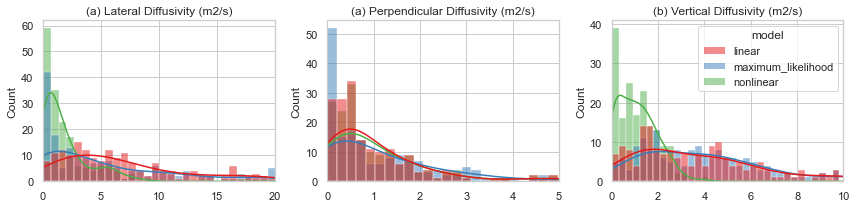

In [151]:
make_diffusivity_comparison_plot(combined_diff_results)

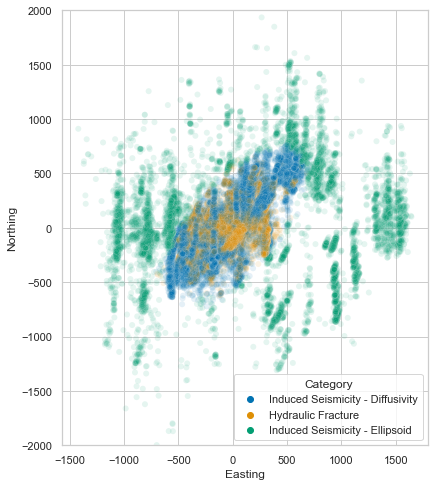

In [153]:
def make_segregation_stage_overlay(bayes_filtered_distances: pd.DataFrame, figsize=(10,8)):
    """Make an overlay of all stages in plan view, differentiating the different
    segregation categories (induced seismicity from plausible ellipsoid or diffusivity 
    vs hydraulic fracture). Adds a category column for the plot.

    Args:
        bayes_filtered_distances (pd.DataFrame): Dataframe of distances with in_frac_ellipsoid, in_diff_ellipsoid columns
        figsize (tuple, optional): _description_. Defaults to (10,8).
    """
    sns.set_style('whitegrid')
    sns.set_palette('colorblind')
    
    bayes_filtered_distances['Category'] = np.where(
        bayes_filtered_distances.in_frac_ellipsoid == False, 'Induced Seismicity - Ellipsoid',
        np.where(bayes_filtered_distances.in_diff_ellipsoid == False, 'Induced Seismicity - Diffusivity',
        'Hydraulic Fracture')
        )

    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=bayes_filtered_distances, x='dx_cart_m', y='dy_cart_m', hue='Category', color=None, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_ylim(-2000,2000)
    ax.set_ylabel('Northing')
    ax.set_xlabel('Easting')
    plt.show()

make_segregation_stage_overlay(nonlinear_filtered_distances)
plt.show()

In [154]:
# microseismic data
ms_data = pd.read_parquet('proprietary/msdata.parquet')
# assign clean columns
datum_y = ms_data.QC_LOC_Y.mean()
datum_x = ms_data.QC_LOC_X.mean()
ms_data['Days'] = (ms_data.JobTime - ms_data.JobTime.min())/pd.Timedelta(1,'d')
ms_data['Magnitude'] = ms_data.SP_MAGNITUDE.astype(np.float16)
ms_data['Event Depth'] = ms_data.QC_LOC_Z.abs().astype(np.float16)
ms_data['Northing'] = ms_data.QC_LOC_Y.abs().astype(np.float32) - datum_y
ms_data['Easting'] = ms_data.QC_LOC_X.abs().astype(np.float32) - datum_x

In [175]:
stagedata = pd.read_csv('proprietary/stagedata.csv')
stagedata['Easting'] = stagedata['mid_x'] - datum_x
stagedata['Northing'] = stagedata['mid_y'] - datum_y
stagedata['Depth'] = -stagedata['mid_z']

In [159]:
linear_bayes_ms_data = pd.merge(ms_data, linear_filtered_distances, on='MS_EVENT_ID', how='inner')
linear_hf_data = linear_bayes_ms_data.query("in_frac_ellipsoid").query("in_diff_ellipsoid").copy()
linear_is_data = linear_bayes_ms_data.query("(in_diff_ellipsoid == False) | (in_frac_ellipsoid == False)").copy()

nonlinear_bayes_ms_data = pd.merge(ms_data, nonlinear_filtered_distances, on='MS_EVENT_ID', how='inner')
nonlinear_hf_data = nonlinear_bayes_ms_data.query("in_frac_ellipsoid").query("in_diff_ellipsoid").copy()
nonlinear_is_data = nonlinear_bayes_ms_data.query("(in_diff_ellipsoid == False) | (in_frac_ellipsoid == False)").copy()

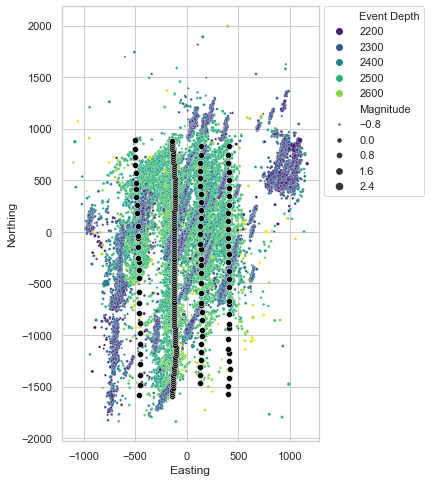

In [168]:
# all data - plan view
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cmap = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=ms_data, x='Easting', y='Northing', size='Magnitude', hue='Event Depth', legend=True, sizes=(1,50), palette=cmap, ax=ax)
sns.scatterplot(data=stagedata.sort_values(['uwi','md_mid_m']), x='Easting', y='Northing', color='black', ax=ax)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.show()

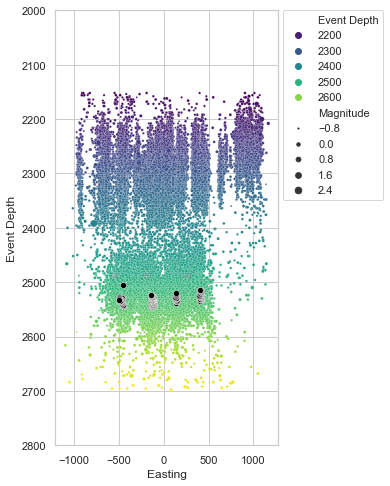

In [184]:
# all data - gun barrell
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cmap = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(4,8))
sns.scatterplot(data=ms_data, x='Easting', y='Event Depth', size='Magnitude', hue='Event Depth', legend=True, sizes=(1,50), palette=cmap, ax=ax)
sns.scatterplot(data=stagedata.sort_values(['uwi','md_mid_m']), x='Easting', y='Depth', color='black', ax=ax)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.ylim(2800, 2000)
plt.show()

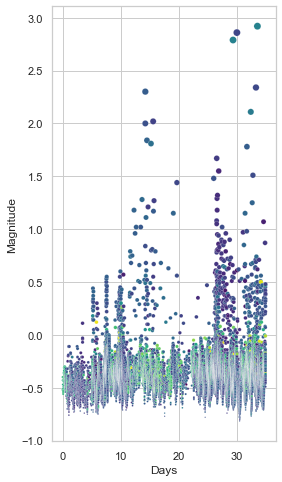

In [183]:
# make time series plot (without stages)
cmap = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(4,8))
sns.scatterplot(data=ms_data, x='Days', y='Magnitude', size='Magnitude', hue='Event Depth', legend=False, sizes=(1,50), palette=cmap, ax=ax)
plt.show()

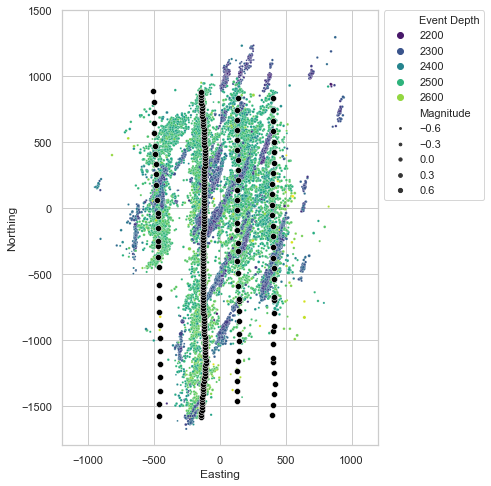

In [196]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
cmap = sns.color_palette("viridis", as_cmap=True)
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=nonlinear_hf_data, x='Easting', y='Northing', size='Magnitude', hue='Event Depth', legend=True, sizes=(1,20), palette=cmap, ax=ax)
sns.scatterplot(data=stagedata.sort_values(['uwi','md_mid_m']), x='Easting', y='Northing', color='black', ax=ax)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
plt.ylim(-1800,1500)
plt.xlim(-1200,1200)
plt.show()
